# Task 1 - Add Values

**Input** 
- List _ram_ containing _n_ integers
- An integer _num_

**Output**
- All subsets of the list _ram_ that sum up to _num_

## Overall Solution

Use Grover's algorithm to find all subsets of list _ram_ that add up to value _num_. 

The main steps of Grover's algorithm include :

1. Initial state: Start with an equal super position of all possible subsets of the list _ram_.

2. Grover's Operator: Amplify the probability of subsets which sum up to _num_. 

#### Import Qiskit libraies

In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

from qiskit.circuit.library.basis_change import QFT
from qiskit.circuit.quantumregister import QuantumRegister
from qiskit.circuit.classicalregister import ClassicalRegister
from qiskit.circuit.library.standard_gates import XGate,ZGate
from qiskit.circuit.library import GroverOperator
from qiskit.algorithms import AmplificationProblem
from qiskit.algorithms import Grover

# Loading your IBM Quantum account(s)
#provider = IBMQ.load_account()

#### Input to the program

In [2]:
n = 5 # Number of elements in the list
m = 5 # Number of bits needed to store the integers is 5
num = 16 # The value the sum of the subsets need to be equal to
ram = [5,7,8,9,1] # The list of integers

In [3]:
#Function for initializing register to a value using its binary representation 

def add_num(num):
    
    bin_num = np.binary_repr(num,width=m)
    bin_num = list(bin_num)[::-1]
    
    qr_a = QuantumRegister(m,'a')
    circ = QuantumCircuit(qr_a)
    
    for i in range(len(bin_num)):
        if bin_num[i] =='1':
            circ.x(qr_a[i])
            
    return circ.to_gate(label=f"add {num}")

### Initial State

Initial state consists of an equal superposition of all possible subsets of the list _ram_. The _inp_ register represents the elements present in a subset. It is of length _n_ and each bit in the register represents if that particular element of the list _ram_ is present in the subset. For example: If _ram_ = [ 5,7,8,9,1] and subset is [5,8], the value of _inp_ is [1,0,1,0,0]. Initially as we need an equal superposition of all 32 subsets, we apply Hadamard operation to the _inp_ register. Inorder to apply Grover's algorithm we need to mark all valid subsets with a negative phase. To denote the validity of the subset in _inp_ register we use _op_ register. Its value is 1 if the _inp_ register is representing a valid subset. A subset is valid if its sum is equal to _num_. The procedure to calculate the value of _op_ register is as follows.

1. The elements in the list _ram_ are stored internally and controlled by _inp_ register. 
2. Draper's adder is used for adding the elements in the subset represented by _inp_ register. An element is in the subset if it's equivalent bit is set to one in the _inp_ register. The Draper's adder needs two register _a_ and _b_ to compute the summation. It computes the sum of _a_ and _b_ and stores it in the _b_ register. The procedure to compute the sum of the subset is to initialize _b_ register to zero. Set value of _a_ to different elements in the list and add them to _b_ only if it is present in the subset denoted by _inp_ register.  Example: _inp_ - [1,1,0,0,0] -> _b_ = 0+5+7 . _inp_ - [0,0,0,1,0], _b_ = 0 + 9.

3. A comparator is used for checking if the sum of the subset in _b_ is equal to _num_. If True then _op_ is set to 1.

Hence, the above circuit can mark good states by setting value of _op_ register to 1.

In [4]:
inp = QuantumRegister(n,'inp') # Represent the subset

qr_a = QuantumRegister(m,'a') 
qr_b = QuantumRegister(m,'b') # Store the sum of subset

op = QuantumRegister(1,'op') # Mark good state

init = QuantumCircuit(*[inp,qr_a,qr_b,op]) # Initial state preparation circuit

init.h(inp) # Equal superposition of all subsets 


init.append(QFT(m, do_swaps=False).to_gate(), qr_b)

for i in range(n):
    controlled_add = add_num(ram[i]).control(1)
    # Initialize register a to ith element if it is present in subset. Else 0
    init.append(controlled_add,[inp[i]]+[qr_a[_] for _ in range(m)])

    # Add a to b
    for j in range(m):
        for k in range(m - j):
            lam = np.pi / (2 ** k)
            init.cp(lam, qr_a[j], qr_b[j + k])

    # Initialize register a to 0
    init.append(controlled_add,[inp[i]]+[qr_a[_] for _ in range(m)])

init.append(QFT(m, do_swaps=False).inverse().to_gate(), qr_b)


# Compare if the value of b is equal to num. Set op = 1 if equal.

bin_num = np.binary_repr(num,width=m) # binary representation of num
bin_num = list(bin_num)[::-1]

for i in range(len(bin_num)):
    if bin_num[i] =='0':
        init.x(qr_b[i])

comparator_gate = XGate().control(m)
init.append(comparator_gate,[qr_b[_] for _ in range(m)]+[op[0]])


### Oracle

Oracle is used to add negative phases to good states. In this case it is enough to compare the value of register _b_ and check if it is equal to _num_.

In [5]:
oracle = QuantumCircuit(*[inp,qr_a,qr_b,op])
        
        
comparator_gate = XGate().control(m)

oracle.append(comparator_gate,[qr_b[_] for _ in range(m)]+[op[0]])


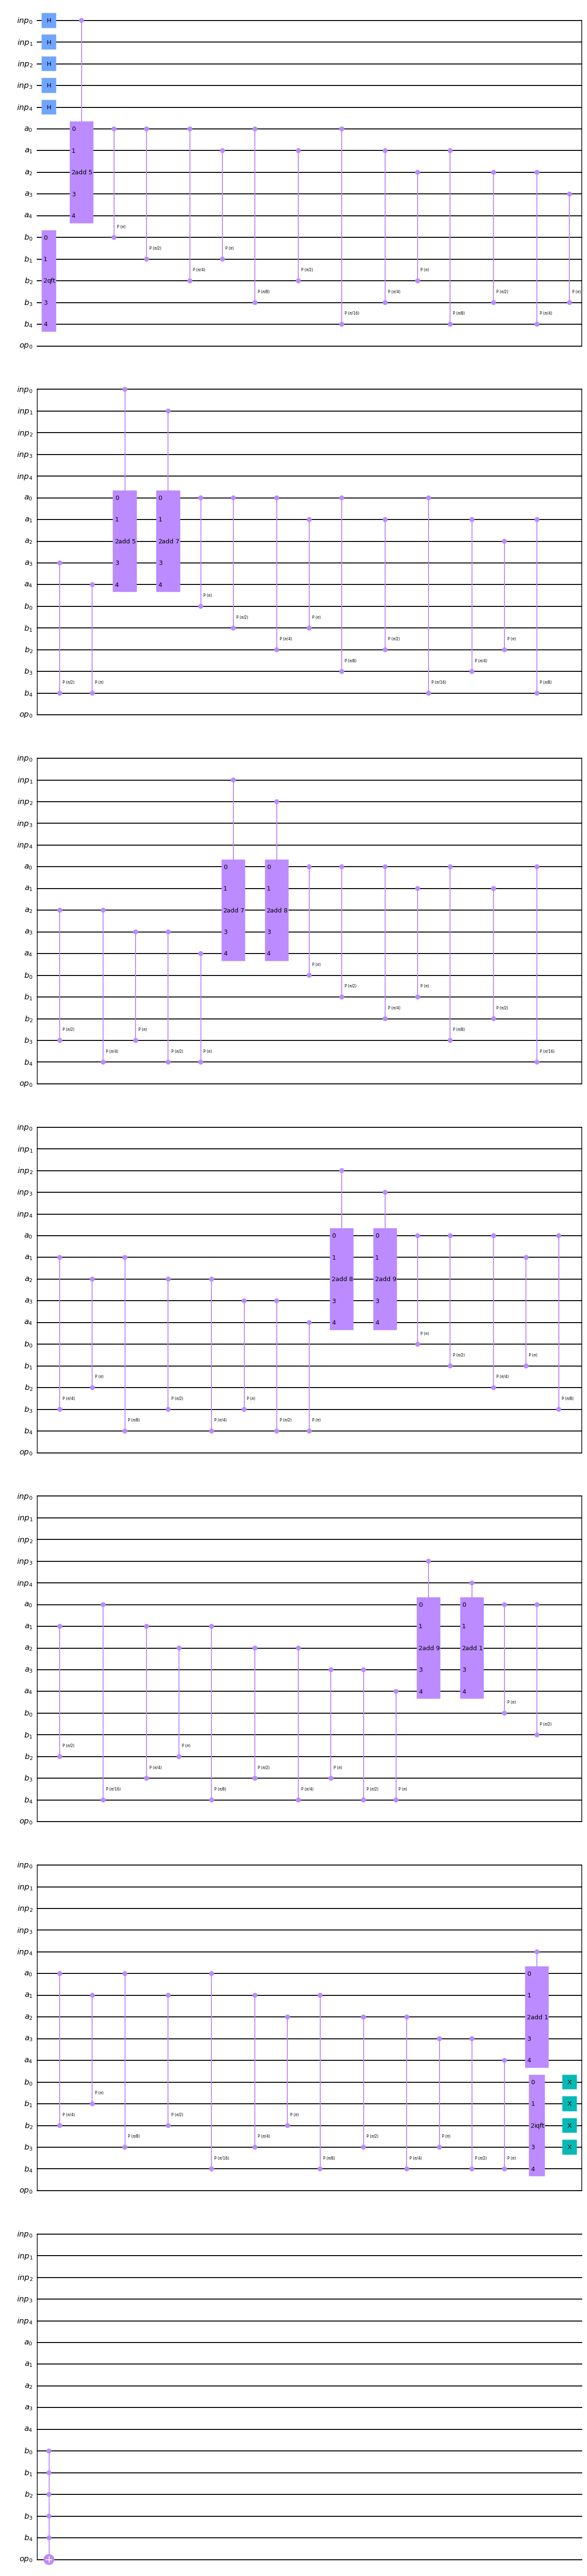

In [6]:
init.draw('mpl')


In [7]:
# Function for determining if a state is good. If op == 1 -> Good state.
def good_state(s):
    #print([s[0],s[1:5],s[5:9],s[9:]],[s[:5],s[5:9],s[9:13],s[13:]])
    #print(s)
    if s[0] =="1":
        return True
    else:
        return False

In [8]:
#Run Grover's algorithm by using the initial state and oracle defined earlier

problem = AmplificationProblem(oracle, state_preparation= init, is_good_state=good_state)
aer_simulator = Aer.get_backend('aer_simulator',shots=1000)
grover = Grover(quantum_instance=aer_simulator)
result = grover.amplify(problem)

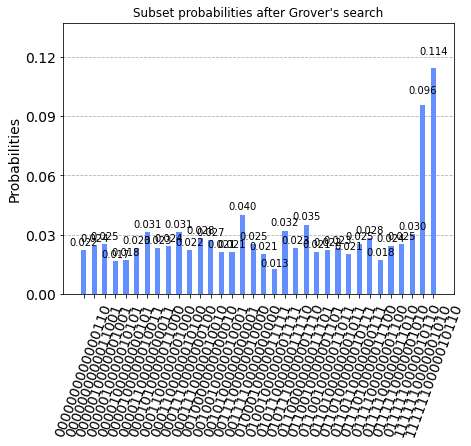

In [9]:
counts=result.circuit_results
counts = counts[-1]
plot_histogram(counts, title='Subset probabilities after Grover\'s search')

### Results

The circuit is executed for 1000 times and the probabilities of different state measured is plotted in the above figure. It can be observed that the circuit produces two states with high probabilties 0101000000111111 and 0110100000111111 (Qiskit measures the states in reverse order). In both of the states _op_ = 1 and the _inp_ register states are - 01010 and 01101. This represents the subsets [7,9] and [7,8,1]. Sum of both the subsets is equal to 16.

In [10]:
#Print the subsets with high probability.

for key,val in counts.items():
    if val>50:
        res = list(key[-5:])
        res = np.array([int(r) for r in res])
        res = np.extract(res,ram[::-1])
        print(f"inp register : {key[-5:][::-1]}, Subset : {res}, Sum : {sum(res)}")

inp register : 01101, Subset : [1 8 7], Sum : 16
inp register : 01010, Subset : [9 7], Sum : 16
